In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, ranksums, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import multipletests

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')
clustering_resolution = 0.3

#os.chdir('/home/ak431480')

## Load data

In [2]:
adata = sc.read_h5ad('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.h5ad')
adata.obs['type'] = adata.obs['type'].cat.reorder_categories(['PC','HSPC','CRPC'])

# Drop CRPCs
adata = adata[~(adata.obs['type'] == 'CRPC')]

# Drop Cycling cells
adata = adata[~(adata.obs['cell_type'] == 'Cycling cell')]

In [ ]:
adata.obs_names_make_unique()

# Create an empty column to hold cluster assignments
adata.obs['celltype_leiden'] = None  

# Iterate over all cell types
for ctype in tqdm(adata.obs['cell_type'].unique()):
    print(f'Processing {ctype}...')
    adata_subset = adata[adata.obs['cell_type'] == ctype].copy()
    
    # Compute neighbors and Leiden within this subset
    sc.pp.neighbors(adata_subset, use_rep='X_pca_harmony',random_state=24664712)
    sc.tl.leiden(adata_subset, resolution=0.3, key_added='leiden_tmp')
    
    # Map results back into the main object
    adata.obs.loc[adata_subset.obs_names, 'celltype_leiden'] = (
        ctype + '_' + adata_subset.obs['leiden_tmp'].astype(str)
    )


In [ ]:
# Drop cellular subtypes present with < 50 genes
drop_cell_subtypes = adata.obs['celltype_leiden'].value_counts()[adata.obs['celltype_leiden'].value_counts() < 50].index.to_list()

adata = adata[~(adata.obs['celltype_leiden'].isin(drop_cell_subtypes))]
n_types = len(adata.obs['celltype_leiden'].value_counts())
# Summary
print(f'{n_types} unique categories:')
adata.obs['celltype_leiden'].value_counts()

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

In [ ]:
adata.write('./scs_data_clustered_annotated_250611_cellular_subtypes_for_cell2location.h5ad')

In [ ]:
### Find clusters that are mostly from a single sample and most likely technological

obs_data = adata.obs.copy()

vcounts = obs_data['celltype_leiden'].value_counts()

results = []  # collect rows

for col in vcounts.index:
    samplecounts = (
        obs_data[obs_data['celltype_leiden'] == col]['sample']
        .value_counts(normalize=True)
    )
    top_pct = samplecounts.iloc[0]*100
    top_sample = samplecounts.index[0]
    results.append({
        'celltype_leiden': col,
        'top_sample': top_sample,
        'top_pct': top_pct,
        'n_unique_samples': len(samplecounts[samplecounts != 0])
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index('celltype_leiden')

# Sort by descending top_pct
summary_df = summary_df.sort_values(by='top_pct', ascending=False)

sns.set_theme(style='white',font_scale=0.6,rc={
    'xtick.bottom': True,
    'ytick.left': True})

fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(summary_df['top_pct'],binwidth=10, kde=True, ax=ax)
ax.spines[['top','right']].set_visible(False)
ax.axvline(x=75,linestyle='--', color='firebrick')
plt.show()

clusters_to_drop = summary_df[summary_df['top_pct'] > 75].index.tolist()
summary_df.loc[clusters_to_drop]


In [ ]:
# Drop the clusters
adata = adata[~(adata.obs['celltype_leiden'].isin(clusters_to_drop))]

In [ ]:
adata.obs['celltype_leiden'].value_counts()

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

In [ ]:
# Save the adata object
adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_{formatted_date}.h5ad')

## Calculate differential expression

In [ ]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()

In [ ]:
# One cluster vs all rest

output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers_vs_baseline_of_all_other.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}
category_results = []
# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    deg_results_df['annotation'] = g  # mark which group this came from
    category_results.append(deg_results_df)

combined_df = pd.concat(category_results, ignore_index=True)
combined_df.to_excel(writer, sheet_name='DEGs', index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


In [ ]:
output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}

# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'
    marker_genes_dict[g] = top_genes_str

# Second pass: within-category DEGs
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:
    celltype_groups = [c for c in celltypes if top_category in c]

    adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
    sc.tl.rank_genes_groups(
        adata,
        groupby='celltype_leiden',
        groups=celltype_groups,
        reference='rest',
        layer='log1p',
        use_raw=False
    )

    category_results = []

    for g in celltype_groups:
        deg_results_df = sc.get.rank_genes_groups_df(adata, group=g, log2fc_min=1, pval_cutoff=0.05)
        deg_results_df['annotation'] = g  # mark which group this came from
        category_results.append(deg_results_df)

        # Update marker gene string
        marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'

    # Concatenate and save to Excel tab for this top_category
    if category_results:
        combined_df = pd.concat(category_results, ignore_index=True)
        combined_df.to_excel(writer, sheet_name=top_category[:31], index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


## Plot cluster markers on umap

In [ ]:
# Calculate the differentially expressed genes in each group, put them into a string
marker_genes_dict = {}

sc.tl.rank_genes_groups(scs_adata,
        groupby='celltype_leiden',
        reference='rest',
        layer='log1p',
        use_raw=False)

for g in celltypes:
        deg_results_df = sc.get.rank_genes_groups_df(scs_adata,group=g,log2fc_min=1,pval_cutoff=0.05)

        # Extract the genes with the top 3 highest scores
        top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'

        marker_genes_dict[g] = top_genes_str

# Second pass, markers for within the celltype group
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:

        celltype_groups = [c for c in celltypes if top_category in c]

        adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
        sc.tl.rank_genes_groups(adata,
                groupby='celltype_leiden',
                groups=celltype_groups,
                reference='rest',
                layer='log1p',
                use_raw=False)

        for g in celltype_groups:
                deg_results_df = sc.get.rank_genes_groups_df(adata,group=g,log2fc_min=1,pval_cutoff=0.05)

                # Extract the genes with the top 3 highest scores
                marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'


In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# ensure UMAP is computed
if 'X_umap' not in scs_adata.obsm:
    sc.tl.umap(scs_adata)

# extract coordinates
umap = scs_adata.obsm['X_umap']
clusters = scs_adata.obs['celltype_leiden'].cat.categories

# set up grid
fig, axes = plt.subplots(9, 5, figsize=(12, 20))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    highlight = scs_adata.obs['celltype_leiden'] == cluster

    # plot all cells in lightgray
    ax.scatter(umap[:, 0], umap[:, 1], s=0.1, color='lightgray', alpha=0.5, rasterized=True)
    # plot highlighted cluster in firebrick
    ax.scatter(umap[highlight, 0], umap[highlight, 1], s=0.1, color='firebrick', rasterized=True)

    ax.set_title(str(cluster) + ' ' + marker_genes_dict[cluster], fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# turn off extra axes if < 21 clusters
for j in range(len(clusters), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('/home/ak431480/shafi_explant_project/plots/scs_celltype_leiden_separately_highted_on_umap.pdf')
plt.show()


## Plot celltype fractions by treatment

In [3]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
scs_adata.obs_names = scs_adata.obs['sample'].astype(str) + '_' + scs_adata.obs_names

adata = scs_adata[scs_adata.obs['cell_type'] == 'Epithelial cell']

celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()



In [4]:
# 1% threshold
min_cells = len(adata) * 0.01

# celltype sizes
counts = adata.obs['celltype_leiden'].value_counts()

# categories to remove
to_remove = counts[counts < min_cells].index

# filter adata
adata = adata[~adata.obs['celltype_leiden'].isin(to_remove)].copy()


In [5]:
prostate_lineage_signatures_dict = {}
prostate_lineage_signatures = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
for gset in tqdm(prostate_lineage_signatures.columns):
    if 'Lum–' in gset:
        sig = prostate_lineage_signatures['Luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if 'dLum' in gset:
        sig = prostate_lineage_signatures['Duct luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if '_Basal' in gset:
        sig = prostate_lineage_signatures['Basal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    else:
        sig = prostate_lineage_signatures[gset].dropna().tolist()
    sc.tl.score_genes(adata,sig,score_name=gset,use_raw=False,layer='log1p')
    prostate_lineage_signatures_dict[gset] = prostate_lineage_signatures[gset].dropna().tolist()

celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()

  2%|▏         | 1/46 [00:00<00:37,  1.19it/s]

 11%|█         | 5/46 [00:04<00:34,  1.20it/s]

 33%|███▎      | 15/46 [00:12<00:25,  1.21it/s]

 37%|███▋      | 17/46 [00:14<00:23,  1.23it/s]

 50%|█████     | 23/46 [00:18<00:18,  1.23it/s]

 54%|█████▍    | 25/46 [00:20<00:17,  1.21it/s]

 59%|█████▊    | 27/46 [00:22<00:15,  1.21it/s]

 61%|██████    | 28/46 [00:23<00:15,  1.19it/s]

 65%|██████▌   | 30/46 [00:24<00:13,  1.19it/s]

 67%|██████▋   | 31/46 [00:25<00:12,  1.17it/s]

 70%|██████▉   | 32/46 [00:26<00:11,  1.18it/s]

       'IFNA14', 'IFNA13', 'IFNA17', 'IFNA4', 'CCL3L3', 'IL9'],
      dtype='object')


 72%|███████▏  | 33/46 [00:27<00:10,  1.19it/s]

 74%|███████▍  | 34/46 [00:28<00:10,  1.20it/s]

 78%|███████▊  | 36/46 [00:29<00:08,  1.20it/s]

 80%|████████  | 37/46 [00:30<00:07,  1.19it/s]

 83%|████████▎ | 38/46 [00:31<00:06,  1.18it/s]

 85%|████████▍ | 39/46 [00:32<00:05,  1.19it/s]

 87%|████████▋ | 40/46 [00:33<00:05,  1.18it/s]

 91%|█████████▏| 42/46 [00:35<00:03,  1.16it/s]

 93%|█████████▎| 43/46 [00:35<00:02,  1.19it/s]

100%|██████████| 46/46 [00:38<00:00,  1.20it/s]
/tmp/ipykernel_48655/3143398565.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()


In [6]:
# Only keep cells with a positive CNV status
concat_obs_data = pd.read_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/epithelial_cancer_cell_annotation_20250818.csv',index_col=0)
concat_obs_data.index =  concat_obs_data['sample'].astype(str) + '_' + concat_obs_data.index
cnv_adata = scs_adata[scs_adata.obs_names.isin(concat_obs_data[concat_obs_data['CNV_status'] == 'CNVpos cancer'].index.tolist())].copy()
adata.obs = pd.merge(adata.obs,concat_obs_data[['CNV_status']],left_index=True,right_index=True,how='left')
adata.obs['CNV_status'] = adata.obs['CNV_status'].fillna('Benign')

In [7]:
sc.pp.neighbors(adata,use_rep='X_pca_harmony',random_state=529657)
sc.tl.umap(adata)

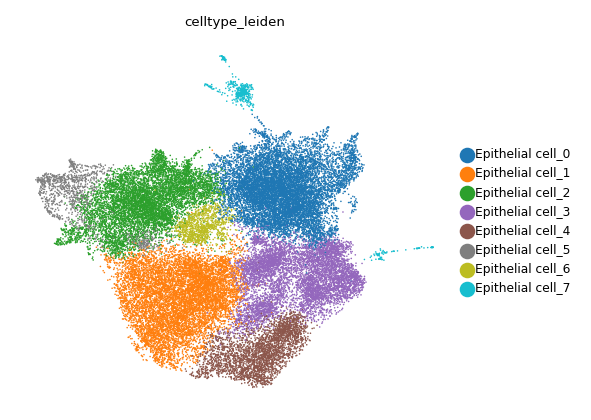

In [8]:
sc.set_figure_params(figsize=(3.5,3),fontsize=6,dpi_save=300)
sc.pl.umap(adata,color='celltype_leiden', size=2,frameon=False,palette='tab10',save='umap.pdf')

In [9]:
cluster_naming_dict = {
    'Epithelial cell_0':'AMACR+ cancer',
    'Epithelial cell_1':'PIGR+ progenitor-like',
    'Epithelial cell_2':'ARhigh mixed identity',
    'Epithelial cell_3':'ARlow mixed identity',
    'Epithelial cell_4':'KRT5+ basal',
    'Epithelial cell_5':'FOLH1+ cancer',
    'Epithelial cell_6':'NKX3-1+ cancer',
    'Epithelial cell_7':'CHGA+ neuroendocrine',

}

adata.obs['epithelial_celltype'] = adata.obs['celltype_leiden'].map(cluster_naming_dict)

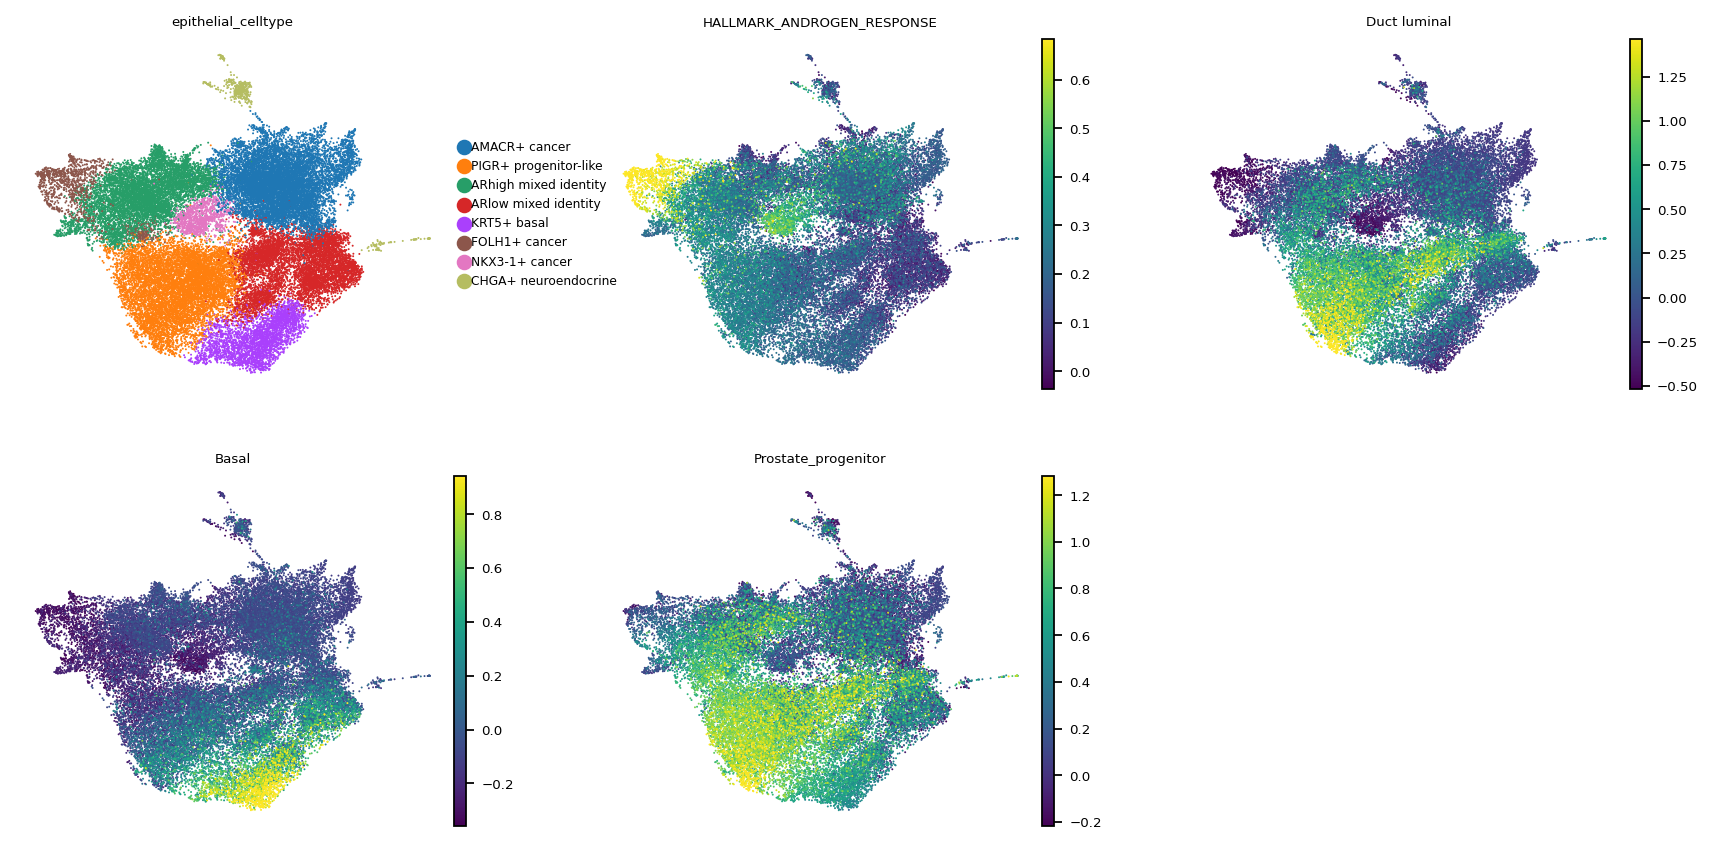

In [10]:
sc.set_figure_params(figsize=(3.5,3),fontsize=6)
sc.pl.umap(adata,color=['epithelial_celltype','HALLMARK_ANDROGEN_RESPONSE','Duct luminal','Basal','Prostate_progenitor'],ncols=3,vmin='p1',vmax='p99',cmap='viridis',frameon=False)

/tmp/ipykernel_48655/1299326464.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['celltype_leiden', group_col])
/tmp/ipykernel_48655/1299326464.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frac.groupby('celltype_leiden')['count'].transform('sum')


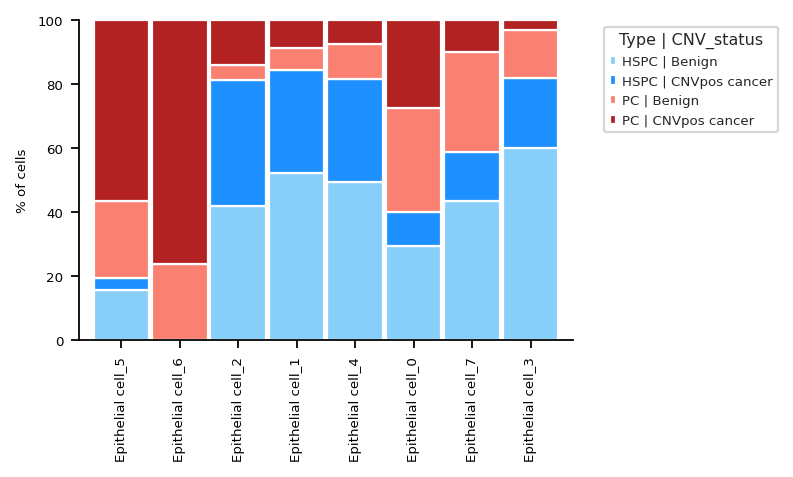

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))

# --- Combine 'type' and 'CNV_status' into one column ---
adata.obs['type_CNV'] = (
    adata.obs['type'].astype(str)
    + ' | ' 
    + adata.obs['CNV_status'].astype(str)
)

# --- Compute fractions per celltype for the combined category ---
def compute_fractions(df, group_col):
    frac = (
        df.groupby(['celltype_leiden', group_col])
        .size()
        .reset_index(name='count')
    )
    frac['fraction'] = (
        frac['count'] /
        frac.groupby('celltype_leiden')['count'].transform('sum')
        * 100
    )
    frac_wide = (
        frac.pivot(index='celltype_leiden', columns=group_col, values='fraction')
        .fillna(0)
    )
    return frac_wide

combined_fraction = compute_fractions(adata.obs, 'type_CNV')

# --- Identify the column that represents cancer ---
# 👉 Replace this with the exact column name in your data
#cancer_col = [c for c in combined_fraction.columns if "PC" in c][0]
cancer_col = 'PC | CNVpos cancer'

# --- Sort using your external celltype_order list ---
combined_fraction = combined_fraction.reindex(celltype_order)

sns.set_theme(
    style='white',
    palette=sns.color_palette(['lightskyblue','dodgerblue','salmon','firebrick']),
    font_scale=0.6,
    rc={'xtick.bottom': True, 'ytick.left': True}
)

# --- Plot ---
combined_fraction.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.95
)

ax.set_ylabel('% of cells')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=6,
    title='Type | CNV_status'
)

plt.tight_layout()
plt.savefig('/home/ak431480/plots/CNA_barplot.pdf')
plt.show()


/tmp/ipykernel_48655/4094182539.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'epithelial_celltype'])
/tmp/ipykernel_48655/4094182539.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts['fraction'] = sample_counts['count'] / sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_48655/4094182539.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_

     epithelial_celltype      pval  pval_adj significance
0          AMACR+ cancer  0.000037  0.000299          ***
1          FOLH1+ cancer  0.000184  0.000491          ***
2         NKX3-1+ cancer  0.000125  0.000491          ***
3   CHGA+ neuroendocrine  0.212543  0.212543             
4            KRT5+ basal  0.014475  0.016542            *
5   ARlow mixed identity  0.005421  0.007228           **
6  PIGR+ progenitor-like  0.001830  0.002928           **
7  ARhigh mixed identity  0.000664  0.001327           **


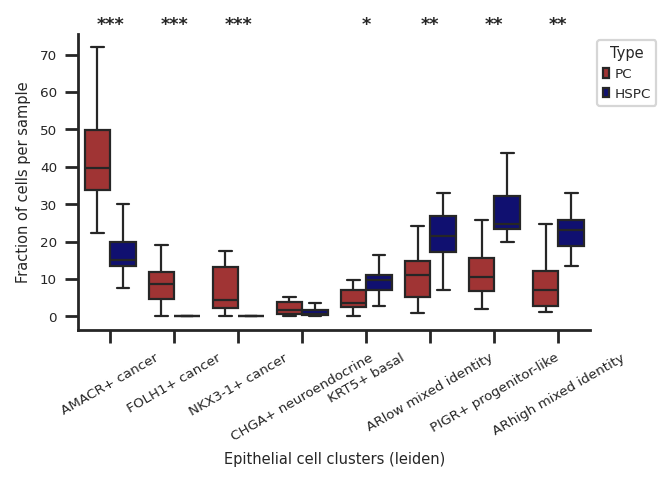

In [12]:
ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, 
              palette=sns.color_palette(['firebrick','navy']),
              rc={'xtick.bottom': True, 'ytick.left': True})

# --- Copy and filter data ---
obs_data = adata.obs.copy()
obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['epithelial_celltype'] = obs_data['epithelial_celltype'].cat.remove_unused_categories()

# Remove low-cell samples
vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >=100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# --- Compute per-sample fractions ---
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'epithelial_celltype'])
    .size()
    .reset_index(name='count')
)
sample_counts['fraction'] = sample_counts['count'] / sample_counts.groupby('sample')['count'].transform('sum')

# Remove mismatched sample/type combos
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# --- Compute median difference PC - HSPC for each cluster ---
medians = (
    sample_counts.groupby(['epithelial_celltype', grpby])['fraction']
    .median()
    .unstack()
)
medians['diff_PC_HSPC'] = medians['PC'] - medians['HSPC']

# --- Order clusters by difference (PC high → left, HSPC high → right) ---
celltype_order = medians.sort_values('diff_PC_HSPC', ascending=False).index.tolist()

# --- Statistical tests (MWU) ---
types = sample_counts[grpby].unique()
pvals = []
for celltype in celltype_order:
    data_sub = sample_counts[sample_counts['epithelial_celltype'] == celltype]
    group1 = data_sub.loc[data_sub['type'] == 'PC', 'fraction']
    group2 = data_sub.loc[data_sub['type'] == 'HSPC', 'fraction']
    if len(group1) > 0 and len(group2) > 0:
        stat, p = ranksums(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'epithelial_celltype': celltype, 'pval': p})

pval_df = pd.DataFrame(pvals)

# --- BH correction ---
pvals_clean = pval_df['pval'].dropna()
reject, pvals_corrected, _, _ = multipletests(pvals_clean, method='fdr_bh')
pval_df['pval_adj'] = np.nan
pval_df.loc[pvals_clean.index, 'pval_adj'] = pvals_corrected

# --- Convert adjusted p-values to significance stars ---
def p_to_star(p):
    if np.isnan(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

pval_df['significance'] = pval_df['pval_adj'].apply(p_to_star)


# Convert to pct
sample_counts['fraction'] = sample_counts['fraction']*100

# --- Plot ---
plt.figure(figsize=(4, 3))
sns.boxplot(
    data=sample_counts,
    x='epithelial_celltype',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    dodge=True,
    fliersize=0
    #linewidth=0.4,
    #size=3
)

# Annotate significance above boxes
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    plt.text(i, 1.05*y_max, row.significance, ha='center', va='bottom', fontsize=8, fontweight='bold')
    #plt.text(i, sample_counts.loc[sample_counts['celltype_leiden'] == row[1],'fraction'].max(), row.significance, ha='center', va='bottom', fontsize=8, fontweight='bold')

print(pval_df)
plt.xlabel('Epithelial cell clusters (leiden)')
plt.ylabel('Fraction of cells per sample')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('/home/ak431480/plots/cluster_fraction_boxplot.pdf')
plt.show()



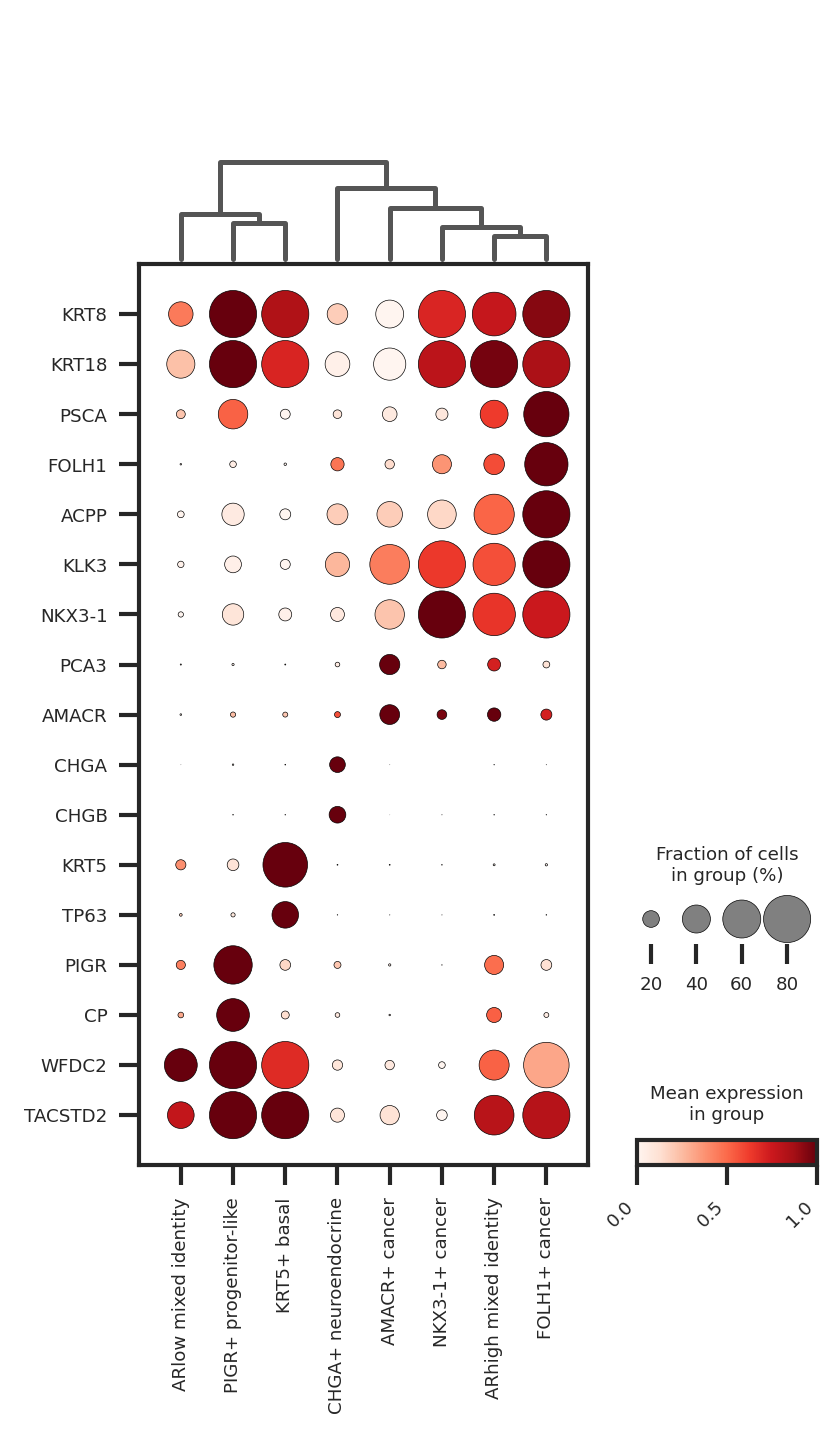

In [13]:
gene_markers = [
    'KRT8','KRT18','PSCA',
    'FOLH1','ACPP',
    'KLK3','NKX3-1',
    'PCA3','AMACR',
    'CHGA','CHGB', 
    'KRT5', 'TP63',
    #'KRT13','LY6D',
    'PIGR','CP',
    'WFDC2','TACSTD2',

]

# --- Plot ---
fig, ax = plt.subplots(figsize=(3.5, 6), dpi=120)
sc.pl.dotplot(
    adata,
    groupby='epithelial_celltype',
    categories_order=celltype_order,
    var_names=gene_markers,
    standard_scale='var',
    dendrogram=True,
    cmap='Reds',
    use_raw=False,
    layer='log1p',
    swap_axes=True,
    dot_max=0.8,
    ax=ax,
    show=False
)
ax.invert_xaxis()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/ak431480/plots/dotplot_sorted.pdf')
plt.show()

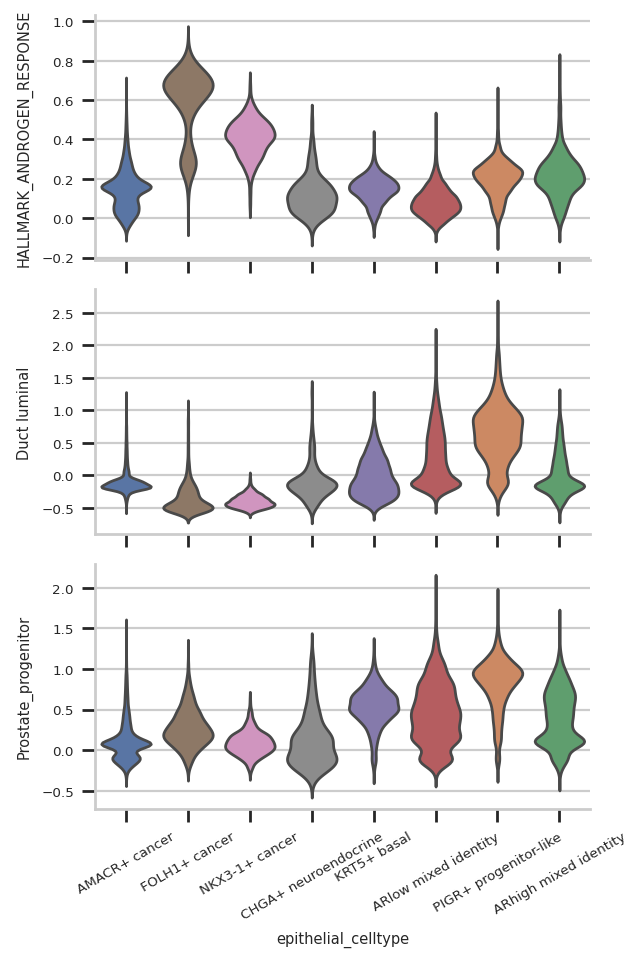

In [14]:
sns.set_theme(style='whitegrid', font_scale=0.55,
    rc={
    'xtick.bottom': True,
    'ytick.left': True
})


signatures = ['HALLMARK_ANDROGEN_RESPONSE','Duct luminal','Prostate_progenitor']

sig = 'HALLMARK_ANDROGEN_RESPONSE'
fig,axs = plt.subplots(3,1,figsize = (4,6),sharex=True)
for i,sig in enumerate(signatures):
    ax = axs[i]
    sns.violinplot(obs_data,
        x = 'epithelial_celltype',
        y = sig,
        order = celltype_order,
        hue = 'epithelial_celltype',
        inner=None,
        ax=ax
    )
    plt.xticks(rotation=30)
    ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig('/home/ak431480/plots/violinplots.pdf')
plt.show()


In [24]:
cell_type_annotation_dict = pd.read_excel('/home/ak431480/single_cell_celltype_annotation.xlsx').set_index('annotation')[['celltype name']].to_dict()['celltype name']
scs_adata.obs['celltype_leiden_annotated'] = scs_adata.obs['celltype_leiden'].map(cell_type_annotation_dict)

In [27]:
# Drop the unannotated epithelial cell clusters
scs_adata = scs_adata[~(scs_adata.obs['celltype_leiden_annotated'] == 'drop')]
scs_adata

View of AnnData object with n_obs × n_vars = 115915 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'celltype_leiden', 'celltype_leiden_annotated'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'

In [29]:
# Save the adata object
scs_adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_{formatted_date}.h5ad')

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
